In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4219306844175067896
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8003283963927523601
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'transfer_learning')
SAVED_DATASET_PATH = "datasets"
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))
#IMAGES_DIR = 'D:\\fall_images' # For 64x64 images
#IMAGES_DIR = 'images'
#IMAGES_DIR = 'D:\img32' # For 32x32 images

## Load base model

In [4]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False

In [5]:
#source_model = change_model(source_model, new_input_shape=(None, 32,32,13),custom_objects={'LeakyReLU':LeakyReLU})

In [6]:
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [7]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

# Coffee vs other
## Model creation

In [23]:
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 38, 38, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Load Data

In [15]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
np.random.shuffle(path1)
class1 = [0]*len(path1)

In [16]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
random.shuffle(path2)
class2 = [1]*len(path2)

In [17]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)
path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.20)

In [101]:
# Params
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
EPOCH = 100
RUN_NAME = 'test'
LOGS_PATH = 'logs'

In [102]:
train_generator = generator(path_train, 
                            y_train, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE, 
                            is_data_augmentation=True)

test_generator = generator(path_test, 
                           y_test, 
                           eurosat_params['mean'], 
                           eurosat_params['std'], 
                           batch_size=BATCH_SIZE, 
                           is_data_augmentation=False)

In [103]:
earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
 77/147 [==============>...............] - ETA: 9s - loss: 2.4839 - accuracy: 0.6449

In [28]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.npy'),history.history)

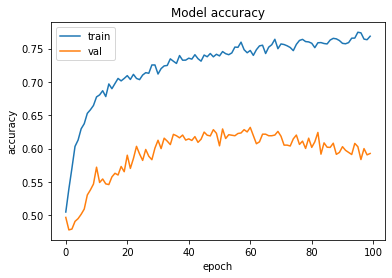

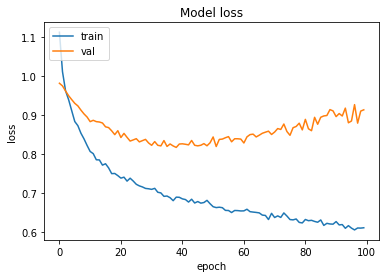

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [17]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model.evaluate_generator(test_generator,30)

[0.6172418137391408, 0.7651042]

In [32]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(final_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [33]:
cm = confusion_matrix(Y_true, Y_pred)

In [34]:
cm

array([[944,  43],
       [473, 460]], dtype=int64)

In [35]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.67      0.96      0.79       987
           1       0.91      0.49      0.64       933

    accuracy                           0.73      1920
   macro avg       0.79      0.72      0.71      1920
weighted avg       0.79      0.73      0.72      1920

F1-Score : 0.6406685236768802


## Spatial Cross val

In [8]:
train_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold', 'train_data.csv')))
train_data['geometry'] = train_data['geometry'].apply(wkt.loads)

In [9]:
nb_0 = len(train_data[train_data['label']==0])
nb_1 = len(train_data[train_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [10]:
nb_labels = train_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.2469879518072289
0.7530120481927711


In [11]:
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

In [12]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_coffee_2'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

In [13]:
def compute_score(geo_val, model):
    
    test_generator = generator(geo_val['path'].to_numpy(), 
                        geo_val['label'].to_numpy(), 
                        eurosat_params['mean'], 
                        eurosat_params['std'], 
                        batch_size=len(geo_val))
    
    model.evaluate(test_generator,steps=1)
    Y_true = []
    Y_pred = []
    for i in range (0,1):
        X, Y = next(test_generator)
        Y_pred.extend(np.where(model.predict(X) > 0.5, 1, 0))

        Y_true.extend(Y.tolist())

    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)
    
    print(classification_report(Y_true, Y_pred))
    print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

Fold 1 Number coffee - train : 316
Fold 1 Number no-coffee - train : 1063
Fold 1 Number coffee - val : 94
Fold 1 Number no-coffee - val : 187
Training for fold 1
-----
Epoch 1/100
63/63 [==============================] - 19s 179ms/step - loss: 1.0199 - accuracy: 0.5202 - precision: 0.7735 - recall: 0.5382 - f1_score_keras: 0.6322 - val_loss: 1.0059 - val_accuracy: 0.4049 - val_precision: 0.5541 - val_recall: 0.4309 - val_f1_score_keras: 0.4834
Epoch 2/100
63/63 [==============================] - 8s 134ms/step - loss: 0.9210 - accuracy: 0.6534 - precision: 0.8188 - recall: 0.7081 - f1_score_keras: 0.7577 - val_loss: 1.0048 - val_accuracy: 0.3659 - val_precision: 0.5209 - val_recall: 0.3956 - val_f1_score_keras: 0.4469
Epoch 3/100
63/63 [==============================] - 9s 138ms/step - loss: 0.8749 - accuracy: 0.6982 - precision: 0.8335 - recall: 0.7608 - f1_score_keras: 0.7934 - val_loss: 0.9928 - val_accuracy: 0.4349 - val_precision: 0.6519 - val_recall: 0.3887 - val_f1_score_keras: 0

Epoch 30/100
63/63 [==============================] - 9s 144ms/step - loss: 0.4868 - accuracy: 0.8610 - precision: 0.9602 - recall: 0.8526 - f1_score_keras: 0.9020 - val_loss: 1.0798 - val_accuracy: 0.5365 - val_precision: 0.7240 - val_recall: 0.5265 - val_f1_score_keras: 0.6077
Epoch 31/100
63/63 [==============================] - 9s 141ms/step - loss: 0.5193 - accuracy: 0.8499 - precision: 0.9434 - recall: 0.8543 - f1_score_keras: 0.8952 - val_loss: 1.0788 - val_accuracy: 0.5430 - val_precision: 0.7554 - val_recall: 0.5194 - val_f1_score_keras: 0.6142
Epoch 32/100
63/63 [==============================] - 9s 141ms/step - loss: 0.4688 - accuracy: 0.8710 - precision: 0.9615 - recall: 0.8667 - f1_score_keras: 0.9108 - val_loss: 1.1020 - val_accuracy: 0.5443 - val_precision: 0.7618 - val_recall: 0.5102 - val_f1_score_keras: 0.6082
Epoch 33/100
63/63 [==============================] - 9s 144ms/step - loss: 0.4913 - accuracy: 0.8525 - precision: 0.9547 - recall: 0.8465 - f1_score_keras: 0.8

63/63 [==============================] - 9s 142ms/step - loss: 0.3839 - accuracy: 0.9093 - precision: 0.9751 - recall: 0.9073 - f1_score_keras: 0.9394 - val_loss: 1.1592 - val_accuracy: 0.5859 - val_precision: 0.7063 - val_recall: 0.5963 - val_f1_score_keras: 0.6450
Epoch 60/100
63/63 [==============================] - 9s 145ms/step - loss: 0.4372 - accuracy: 0.8873 - precision: 0.9606 - recall: 0.8910 - f1_score_keras: 0.9236 - val_loss: 1.1181 - val_accuracy: 0.6003 - val_precision: 0.7396 - val_recall: 0.5784 - val_f1_score_keras: 0.6470
Epoch 61/100
63/63 [==============================] - 9s 140ms/step - loss: 0.4013 - accuracy: 0.8925 - precision: 0.9614 - recall: 0.8936 - f1_score_keras: 0.9255 - val_loss: 1.2139 - val_accuracy: 0.5612 - val_precision: 0.6980 - val_recall: 0.5578 - val_f1_score_keras: 0.6192
Epoch 62/100
63/63 [==============================] - 9s 139ms/step - loss: 0.4083 - accuracy: 0.8931 - precision: 0.9688 - recall: 0.8888 - f1_score_keras: 0.9269 - val_los

63/63 [==============================] - 9s 140ms/step - loss: 0.3817 - accuracy: 0.9009 - precision: 0.9662 - recall: 0.9021 - f1_score_keras: 0.9323 - val_loss: 1.2651 - val_accuracy: 0.5755 - val_precision: 0.7352 - val_recall: 0.5619 - val_f1_score_keras: 0.6345
Epoch 89/100
63/63 [==============================] - 9s 143ms/step - loss: 0.3634 - accuracy: 0.9105 - precision: 0.9711 - recall: 0.9117 - f1_score_keras: 0.9399 - val_loss: 1.2408 - val_accuracy: 0.5885 - val_precision: 0.7433 - val_recall: 0.5903 - val_f1_score_keras: 0.6545
Epoch 90/100
63/63 [==============================] - 9s 143ms/step - loss: 0.3862 - accuracy: 0.9064 - precision: 0.9706 - recall: 0.9064 - f1_score_keras: 0.9370 - val_loss: 1.2233 - val_accuracy: 0.5938 - val_precision: 0.7430 - val_recall: 0.5805 - val_f1_score_keras: 0.6481
Epoch 91/100
63/63 [==============================] - 9s 143ms/step - loss: 0.3645 - accuracy: 0.9089 - precision: 0.9743 - recall: 0.9068 - f1_score_keras: 0.9389 - val_los

Epoch 14/100
60/60 [==============================] - 9s 148ms/step - loss: 0.7226 - accuracy: 0.7275 - precision: 0.9178 - recall: 0.6763 - f1_score_keras: 0.7764 - val_loss: 0.7627 - val_accuracy: 0.6396 - val_precision: 0.9777 - val_recall: 0.6116 - val_f1_score_keras: 0.7517
Epoch 15/100
60/60 [==============================] - 9s 148ms/step - loss: 0.7041 - accuracy: 0.7442 - precision: 0.9302 - recall: 0.6841 - f1_score_keras: 0.7874 - val_loss: 0.7828 - val_accuracy: 0.6135 - val_precision: 0.9807 - val_recall: 0.5841 - val_f1_score_keras: 0.7303
Epoch 16/100
60/60 [==============================] - 9s 151ms/step - loss: 0.6773 - accuracy: 0.7412 - precision: 0.9417 - recall: 0.6807 - f1_score_keras: 0.7893 - val_loss: 0.7513 - val_accuracy: 0.6396 - val_precision: 0.9798 - val_recall: 0.6141 - val_f1_score_keras: 0.7531
Epoch 17/100
60/60 [==============================] - 9s 150ms/step - loss: 0.6795 - accuracy: 0.7447 - precision: 0.9247 - recall: 0.6971 - f1_score_keras: 0.7

60/60 [==============================] - 9s 149ms/step - loss: 0.5333 - accuracy: 0.7960 - precision: 0.9524 - recall: 0.7501 - f1_score_keras: 0.8377 - val_loss: 0.6646 - val_accuracy: 0.7104 - val_precision: 0.9966 - val_recall: 0.6806 - val_f1_score_keras: 0.8085
Epoch 44/100
60/60 [==============================] - 9s 150ms/step - loss: 0.5280 - accuracy: 0.8104 - precision: 0.9432 - recall: 0.7771 - f1_score_keras: 0.8512 - val_loss: 0.6558 - val_accuracy: 0.6906 - val_precision: 0.9948 - val_recall: 0.6605 - val_f1_score_keras: 0.7930
Epoch 45/100
60/60 [==============================] - 9s 146ms/step - loss: 0.5251 - accuracy: 0.8182 - precision: 0.9534 - recall: 0.7822 - f1_score_keras: 0.8580 - val_loss: 0.6454 - val_accuracy: 0.7042 - val_precision: 0.9983 - val_recall: 0.6740 - val_f1_score_keras: 0.8034
Epoch 46/100
60/60 [==============================] - 9s 148ms/step - loss: 0.5024 - accuracy: 0.8218 - precision: 0.9645 - recall: 0.7825 - f1_score_keras: 0.8625 - val_los

60/60 [==============================] - 9s 147ms/step - loss: 0.4788 - accuracy: 0.8288 - precision: 0.9547 - recall: 0.8020 - f1_score_keras: 0.8688 - val_loss: 0.6515 - val_accuracy: 0.7031 - val_precision: 0.9850 - val_recall: 0.6817 - val_f1_score_keras: 0.8040
Epoch 73/100
60/60 [==============================] - 9s 149ms/step - loss: 0.4499 - accuracy: 0.8479 - precision: 0.9572 - recall: 0.8226 - f1_score_keras: 0.8831 - val_loss: 0.6514 - val_accuracy: 0.7010 - val_precision: 0.9915 - val_recall: 0.6732 - val_f1_score_keras: 0.8002
Epoch 74/100
60/60 [==============================] - 9s 146ms/step - loss: 0.4623 - accuracy: 0.8487 - precision: 0.9616 - recall: 0.8194 - f1_score_keras: 0.8833 - val_loss: 0.6571 - val_accuracy: 0.6906 - val_precision: 0.9913 - val_recall: 0.6624 - val_f1_score_keras: 0.7931
Epoch 75/100
60/60 [==============================] - 9s 146ms/step - loss: 0.4757 - accuracy: 0.8358 - precision: 0.9534 - recall: 0.8070 - f1_score_keras: 0.8731 - val_los

4/4 [==============================] - 0s 111ms/step - loss: 0.7309 - accuracy: 0.6719 - precision: 0.9735 - recall: 0.6476 - f1_score_keras: 0.7764
Fold 2 loss : 0.7308766841888428
Fold 2 accuracy : 0.671875
Fold 2 F1-score : 0.7763605117797852
1/1 [==============================] - 3s 3s/step - loss: 0.6502 - accuracy: 0.6826 - precision: 0.9905 - recall: 0.6531 - f1_score_keras: 0.7872
[[ 35   1]
 [109 211]]
              precision    recall  f1-score   support

           0       0.24      0.97      0.39        36
           1       1.00      0.66      0.79       320

    accuracy                           0.69       356
   macro avg       0.62      0.82      0.59       356
weighted avg       0.92      0.69      0.75       356

F1-Score : 0.793233082706767


Fold 3 Number coffee - train : 292
Fold 3 Number no-coffee - train : 1059
Fold 3 Number coffee - val : 118
Fold 3 Number no-coffee - val : 191
Training for fold 3
-----
Epoch 1/100
63/63 [==============================] - 17s 1

Epoch 27/100
63/63 [==============================] - 9s 140ms/step - loss: 0.5612 - accuracy: 0.8081 - precision: 0.9458 - recall: 0.8014 - f1_score_keras: 0.8662 - val_loss: 0.5373 - val_accuracy: 0.8268 - val_precision: 0.8318 - val_recall: 0.9146 - val_f1_score_keras: 0.8704
Epoch 28/100
63/63 [==============================] - 9s 139ms/step - loss: 0.5200 - accuracy: 0.8464 - precision: 0.9596 - recall: 0.8397 - f1_score_keras: 0.8949 - val_loss: 0.5268 - val_accuracy: 0.8477 - val_precision: 0.8574 - val_recall: 0.9119 - val_f1_score_keras: 0.8829
Epoch 29/100
63/63 [==============================] - 9s 138ms/step - loss: 0.5324 - accuracy: 0.8246 - precision: 0.9444 - recall: 0.8301 - f1_score_keras: 0.8829 - val_loss: 0.5357 - val_accuracy: 0.8307 - val_precision: 0.8333 - val_recall: 0.9072 - val_f1_score_keras: 0.8668
Epoch 30/100
63/63 [==============================] - 9s 141ms/step - loss: 0.5295 - accuracy: 0.8433 - precision: 0.9511 - recall: 0.8438 - f1_score_keras: 0.8

63/63 [==============================] - 9s 140ms/step - loss: 0.4730 - accuracy: 0.8557 - precision: 0.9485 - recall: 0.8618 - f1_score_keras: 0.9019 - val_loss: 0.4909 - val_accuracy: 0.8307 - val_precision: 0.8289 - val_recall: 0.9187 - val_f1_score_keras: 0.8704
Epoch 57/100
63/63 [==============================] - 9s 141ms/step - loss: 0.4440 - accuracy: 0.8617 - precision: 0.9537 - recall: 0.8641 - f1_score_keras: 0.9055 - val_loss: 0.4632 - val_accuracy: 0.8411 - val_precision: 0.8420 - val_recall: 0.9161 - val_f1_score_keras: 0.8759
Epoch 58/100
63/63 [==============================] - 9s 137ms/step - loss: 0.4265 - accuracy: 0.8727 - precision: 0.9688 - recall: 0.8669 - f1_score_keras: 0.9139 - val_loss: 0.4722 - val_accuracy: 0.8359 - val_precision: 0.8282 - val_recall: 0.9206 - val_f1_score_keras: 0.8706
Epoch 59/100
63/63 [==============================] - 9s 137ms/step - loss: 0.4546 - accuracy: 0.8620 - precision: 0.9551 - recall: 0.8609 - f1_score_keras: 0.9038 - val_los

63/63 [==============================] - 9s 139ms/step - loss: 0.4145 - accuracy: 0.8843 - precision: 0.9582 - recall: 0.8918 - f1_score_keras: 0.9230 - val_loss: 0.4503 - val_accuracy: 0.8438 - val_precision: 0.8451 - val_recall: 0.9189 - val_f1_score_keras: 0.8805
Epoch 86/100
63/63 [==============================] - 9s 138ms/step - loss: 0.4245 - accuracy: 0.8780 - precision: 0.9585 - recall: 0.8830 - f1_score_keras: 0.9184 - val_loss: 0.4268 - val_accuracy: 0.8503 - val_precision: 0.8482 - val_recall: 0.9274 - val_f1_score_keras: 0.8854
Epoch 87/100
63/63 [==============================] - 8s 134ms/step - loss: 0.4366 - accuracy: 0.8608 - precision: 0.9518 - recall: 0.8668 - f1_score_keras: 0.9063 - val_loss: 0.4555 - val_accuracy: 0.8151 - val_precision: 0.8131 - val_recall: 0.9036 - val_f1_score_keras: 0.8557
Epoch 88/100
63/63 [==============================] - 9s 138ms/step - loss: 0.4455 - accuracy: 0.8633 - precision: 0.9488 - recall: 0.8705 - f1_score_keras: 0.9070 - val_los

Epoch 11/100
51/51 [==============================] - 8s 167ms/step - loss: 0.8025 - accuracy: 0.6952 - precision: 0.8830 - recall: 0.6824 - f1_score_keras: 0.7680 - val_loss: 0.5775 - val_accuracy: 0.8581 - val_precision: 0.9630 - val_recall: 0.8501 - val_f1_score_keras: 0.9017
Epoch 12/100
51/51 [==============================] - 9s 171ms/step - loss: 0.7903 - accuracy: 0.7037 - precision: 0.8953 - recall: 0.6765 - f1_score_keras: 0.7688 - val_loss: 0.5668 - val_accuracy: 0.8581 - val_precision: 0.9689 - val_recall: 0.8426 - val_f1_score_keras: 0.9008
Epoch 13/100
51/51 [==============================] - 9s 173ms/step - loss: 0.7839 - accuracy: 0.6953 - precision: 0.8970 - recall: 0.6616 - f1_score_keras: 0.7585 - val_loss: 0.5688 - val_accuracy: 0.8490 - val_precision: 0.9641 - val_recall: 0.8359 - val_f1_score_keras: 0.8941
Epoch 14/100
51/51 [==============================] - 8s 167ms/step - loss: 0.7688 - accuracy: 0.7053 - precision: 0.9029 - recall: 0.6718 - f1_score_keras: 0.7

51/51 [==============================] - 8s 167ms/step - loss: 0.5346 - accuracy: 0.8233 - precision: 0.9489 - recall: 0.8047 - f1_score_keras: 0.8705 - val_loss: 0.4360 - val_accuracy: 0.8789 - val_precision: 0.9599 - val_recall: 0.8781 - val_f1_score_keras: 0.9166
Epoch 41/100
51/51 [==============================] - 9s 171ms/step - loss: 0.5727 - accuracy: 0.8147 - precision: 0.9330 - recall: 0.8068 - f1_score_keras: 0.8643 - val_loss: 0.4341 - val_accuracy: 0.8750 - val_precision: 0.9683 - val_recall: 0.8680 - val_f1_score_keras: 0.9152
Epoch 42/100
51/51 [==============================] - 9s 171ms/step - loss: 0.5563 - accuracy: 0.8077 - precision: 0.9348 - recall: 0.7938 - f1_score_keras: 0.8568 - val_loss: 0.4453 - val_accuracy: 0.8691 - val_precision: 0.9701 - val_recall: 0.8601 - val_f1_score_keras: 0.9114
Epoch 43/100
51/51 [==============================] - 8s 168ms/step - loss: 0.5510 - accuracy: 0.7999 - precision: 0.9372 - recall: 0.7800 - f1_score_keras: 0.8495 - val_los

51/51 [==============================] - 9s 169ms/step - loss: 0.4939 - accuracy: 0.8316 - precision: 0.9437 - recall: 0.8260 - f1_score_keras: 0.8804 - val_loss: 0.4418 - val_accuracy: 0.8665 - val_precision: 0.9670 - val_recall: 0.8620 - val_f1_score_keras: 0.9105
Epoch 70/100
51/51 [==============================] - 9s 171ms/step - loss: 0.4894 - accuracy: 0.8440 - precision: 0.9465 - recall: 0.8333 - f1_score_keras: 0.8855 - val_loss: 0.4767 - val_accuracy: 0.8483 - val_precision: 0.9542 - val_recall: 0.8474 - val_f1_score_keras: 0.8976
Epoch 71/100
51/51 [==============================] - 8s 166ms/step - loss: 0.4632 - accuracy: 0.8490 - precision: 0.9540 - recall: 0.8332 - f1_score_keras: 0.8888 - val_loss: 0.4223 - val_accuracy: 0.8789 - val_precision: 0.9699 - val_recall: 0.8741 - val_f1_score_keras: 0.9194
Epoch 72/100
51/51 [==============================] - 9s 172ms/step - loss: 0.4699 - accuracy: 0.8359 - precision: 0.9545 - recall: 0.8162 - f1_score_keras: 0.8792 - val_los

51/51 [==============================] - 8s 168ms/step - loss: 0.4463 - accuracy: 0.8611 - precision: 0.9657 - recall: 0.8400 - f1_score_keras: 0.8979 - val_loss: 0.4560 - val_accuracy: 0.8659 - val_precision: 0.9592 - val_recall: 0.8645 - val_f1_score_keras: 0.9094
Epoch 99/100
51/51 [==============================] - 8s 169ms/step - loss: 0.4518 - accuracy: 0.8499 - precision: 0.9521 - recall: 0.8432 - f1_score_keras: 0.8935 - val_loss: 0.4479 - val_accuracy: 0.8717 - val_precision: 0.9584 - val_recall: 0.8723 - val_f1_score_keras: 0.9124
Epoch 100/100
4/4 [==============================] - 0s 108ms/step - loss: 0.3900 - accuracy: 0.8984 - precision: 0.9683 - recall: 0.9015 - f1_score_keras: 0.9327
Fold 4 loss : 0.3900291621685028
Fold 4 accuracy : 0.8984375
Fold 4 F1-score : 0.932691216468811
1/1 [==============================] - 4s 4s/step - loss: 0.4483 - accuracy: 0.8675 - precision: 0.9668 - recall: 0.8591 - f1_score_keras: 0.9097
[[111  15]
 [ 61 379]]
              precision 

Epoch 24/100
69/69 [==============================] - 9s 127ms/step - loss: 0.5452 - accuracy: 0.8053 - precision: 0.9517 - recall: 0.7829 - f1_score_keras: 0.8578 - val_loss: 1.0581 - val_accuracy: 0.3568 - val_precision: 0.7727 - val_recall: 0.2305 - val_f1_score_keras: 0.3550
Epoch 25/100
69/69 [==============================] - 8s 121ms/step - loss: 0.5497 - accuracy: 0.8137 - precision: 0.9476 - recall: 0.7943 - f1_score_keras: 0.8632 - val_loss: 1.0643 - val_accuracy: 0.3411 - val_precision: 0.7381 - val_recall: 0.2116 - val_f1_score_keras: 0.3284
Epoch 26/100
69/69 [==============================] - 9s 126ms/step - loss: 0.5287 - accuracy: 0.8213 - precision: 0.9601 - recall: 0.7966 - f1_score_keras: 0.8700 - val_loss: 1.0096 - val_accuracy: 0.3906 - val_precision: 0.7766 - val_recall: 0.2552 - val_f1_score_keras: 0.3827
Epoch 27/100
69/69 [==============================] - 9s 126ms/step - loss: 0.5147 - accuracy: 0.8262 - precision: 0.9549 - recall: 0.8085 - f1_score_keras: 0.8

69/69 [==============================] - 8s 124ms/step - loss: 0.4463 - accuracy: 0.8479 - precision: 0.9580 - recall: 0.8349 - f1_score_keras: 0.8914 - val_loss: 0.9552 - val_accuracy: 0.4349 - val_precision: 0.8218 - val_recall: 0.2943 - val_f1_score_keras: 0.4322
Epoch 54/100
69/69 [==============================] - 9s 127ms/step - loss: 0.4472 - accuracy: 0.8504 - precision: 0.9648 - recall: 0.8301 - f1_score_keras: 0.8912 - val_loss: 0.9432 - val_accuracy: 0.4219 - val_precision: 0.8105 - val_recall: 0.2740 - val_f1_score_keras: 0.4082
Epoch 55/100
69/69 [==============================] - 8s 124ms/step - loss: 0.4542 - accuracy: 0.8406 - precision: 0.9556 - recall: 0.8251 - f1_score_keras: 0.8844 - val_loss: 0.9348 - val_accuracy: 0.4323 - val_precision: 0.8627 - val_recall: 0.3014 - val_f1_score_keras: 0.4445
Epoch 56/100
69/69 [==============================] - 8s 124ms/step - loss: 0.4439 - accuracy: 0.8530 - precision: 0.9642 - recall: 0.8363 - f1_score_keras: 0.8951 - val_los

69/69 [==============================] - 8s 123ms/step - loss: 0.4055 - accuracy: 0.8750 - precision: 0.9637 - recall: 0.8665 - f1_score_keras: 0.9119 - val_loss: 0.8944 - val_accuracy: 0.4505 - val_precision: 0.8609 - val_recall: 0.3367 - val_f1_score_keras: 0.4823
Epoch 83/100
69/69 [==============================] - 8s 124ms/step - loss: 0.4312 - accuracy: 0.8596 - precision: 0.9652 - recall: 0.8422 - f1_score_keras: 0.8982 - val_loss: 0.9048 - val_accuracy: 0.4297 - val_precision: 0.7984 - val_recall: 0.3480 - val_f1_score_keras: 0.4823
Epoch 84/100
69/69 [==============================] - 9s 127ms/step - loss: 0.4017 - accuracy: 0.8674 - precision: 0.9716 - recall: 0.8527 - f1_score_keras: 0.9068 - val_loss: 0.9445 - val_accuracy: 0.4115 - val_precision: 0.7891 - val_recall: 0.3367 - val_f1_score_keras: 0.4701
Epoch 85/100
69/69 [==============================] - 8s 124ms/step - loss: 0.4227 - accuracy: 0.8559 - precision: 0.9642 - recall: 0.8376 - f1_score_keras: 0.8954 - val_los

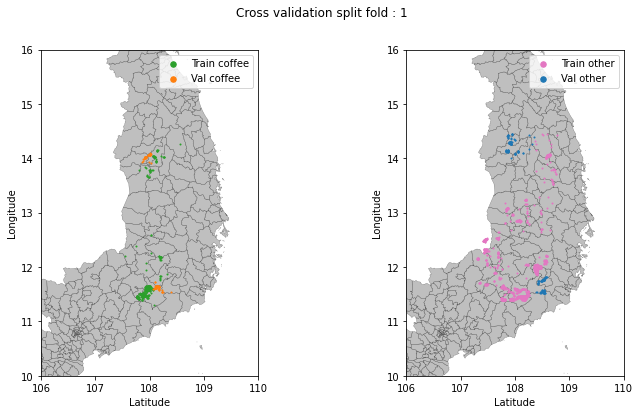

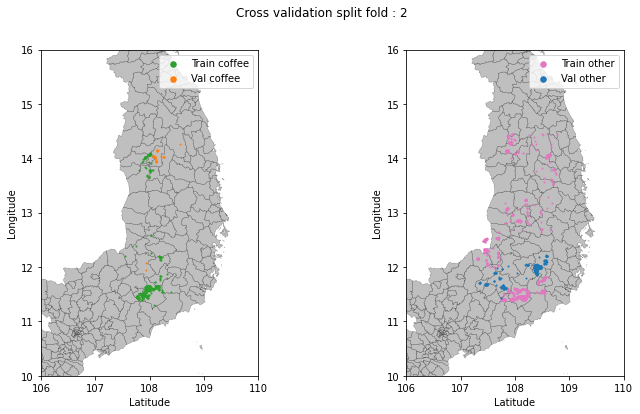

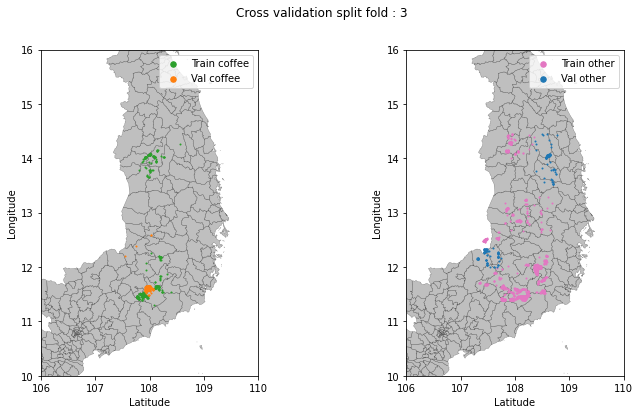

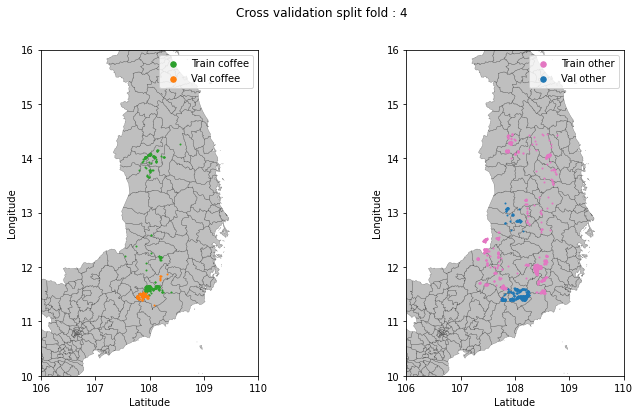

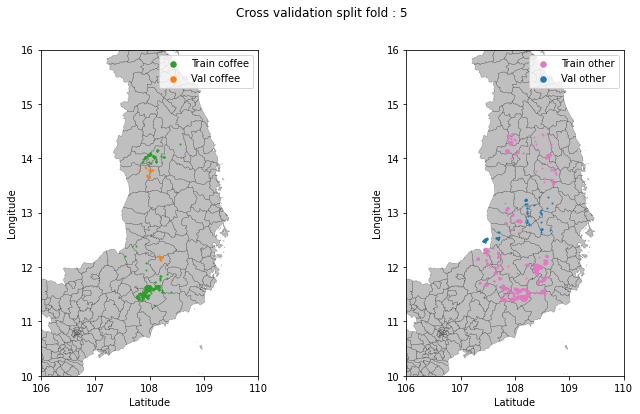

In [14]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [15]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [16]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.67890625
Stdev accuracy : 0.16276270831720022


Mean loss : 0.7581081807613372
Stdev loss : 0.32403876457774805


Mean precision : 0.8665667533874511
Stdev precision : 0.09138519384422589


Mean recall : 0.6679800808429718
Stdev recall : 0.20635272321840106


Mean F1-Score : 0.7370899438858032
Stdev F1-Score : 0.16334845352712718


## Old

In [14]:
NB_FOLD = 10
skcv_coffee = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(other_data['geometry'])
list_fold = []
i = 0

for coffee, other in zip(skcv_coffee, skcv_other):  
    list_fold.append({"train_coffee":coffee[0], "train_other":other[0], "val_coffee":coffee[1], "val_other":other[1]})

In [15]:
random.shuffle(list_fold)

Fold 1 Number coffee - train : 1445
Fold 1 Number no-coffee - train : 5444
Fold 1 Number coffee - val : 384
Fold 1 Number no-coffee - val : 254
-----
Training for fold 0
Epoch 1/100
321/321 [==============================] - 47s 120ms/step - loss: 0.9242 - accuracy: 0.6185 - precision: 0.8058 - recall: 0.6867 - val_loss: 0.9413 - val_accuracy: 0.5648 - val_precision: 0.4760 - val_recall: 0.9534
Epoch 2/100
321/321 [==============================] - 36s 113ms/step - loss: 0.8624 - accuracy: 0.6762 - precision: 0.8258 - recall: 0.7486 - val_loss: 0.8836 - val_accuracy: 0.6852 - val_precision: 0.5793 - val_recall: 0.9231
Epoch 3/100
321/321 [==============================] - 36s 113ms/step - loss: 0.8154 - accuracy: 0.7065 - precision: 0.8412 - recall: 0.7735 - val_loss: 0.8434 - val_accuracy: 0.7274 - val_precision: 0.6073 - val_recall: 0.8955
Epoch 4/100
321/321 [==============================] - 36s 113ms/step - loss: 0.7732 - accuracy: 0.7163 - precision: 0.8499 - recall: 0.7768 - val

Epoch 72/100
321/321 [==============================] - 36s 113ms/step - loss: 0.4353 - accuracy: 0.8331 - precision: 0.9507 - recall: 0.8313 - val_loss: 0.4353 - val_accuracy: 0.8860 - val_precision: 0.8329 - val_recall: 0.8881
Epoch 73/100
321/321 [==============================] - 36s 113ms/step - loss: 0.4416 - accuracy: 0.8271 - precision: 0.9497 - recall: 0.8257 - val_loss: 0.4806 - val_accuracy: 0.8542 - val_precision: 0.7844 - val_recall: 0.8635
Epoch 74/100
321/321 [==============================] - 36s 114ms/step - loss: 0.4458 - accuracy: 0.8229 - precision: 0.9430 - recall: 0.8257 - val_loss: 0.4374 - val_accuracy: 0.8721 - val_precision: 0.8037 - val_recall: 0.8964
Epoch 75/100
321/321 [==============================] - 36s 113ms/step - loss: 0.4425 - accuracy: 0.8330 - precision: 0.9445 - recall: 0.8368 - val_loss: 0.4342 - val_accuracy: 0.8657 - val_precision: 0.8183 - val_recall: 0.8582
Epoch 76/100
321/321 [==============================] - 36s 113ms/step - loss: 0.444

Epoch 4/100
327/327 [==============================] - 36s 110ms/step - loss: 0.8072 - accuracy: 0.6738 - precision: 0.8377 - recall: 0.7099 - val_loss: 0.7721 - val_accuracy: 0.8125 - val_precision: 0.8974 - val_recall: 0.7709
Epoch 5/100
327/327 [==============================] - 36s 110ms/step - loss: 0.7629 - accuracy: 0.7066 - precision: 0.8576 - recall: 0.7417 - val_loss: 0.7401 - val_accuracy: 0.7943 - val_precision: 0.8737 - val_recall: 0.7621
Epoch 6/100
327/327 [==============================] - 36s 110ms/step - loss: 0.7372 - accuracy: 0.7100 - precision: 0.8657 - recall: 0.7317 - val_loss: 0.7001 - val_accuracy: 0.7943 - val_precision: 0.8914 - val_recall: 0.7267
Epoch 7/100
327/327 [==============================] - 36s 110ms/step - loss: 0.7168 - accuracy: 0.7105 - precision: 0.8677 - recall: 0.7311 - val_loss: 0.6795 - val_accuracy: 0.7682 - val_precision: 0.8739 - val_recall: 0.7111
Epoch 8/100
327/327 [==============================] - 36s 110ms/step - loss: 0.6926 - a

Epoch 75/100
327/327 [==============================] - 36s 111ms/step - loss: 0.4496 - accuracy: 0.8236 - precision: 0.9441 - recall: 0.8197 - val_loss: 0.4385 - val_accuracy: 0.8550 - val_precision: 0.9352 - val_recall: 0.8095
Epoch 76/100
327/327 [==============================] - 36s 110ms/step - loss: 0.4538 - accuracy: 0.8238 - precision: 0.9432 - recall: 0.8205 - val_loss: 0.4609 - val_accuracy: 0.8420 - val_precision: 0.9344 - val_recall: 0.7842
Epoch 77/100
327/327 [==============================] - 36s 110ms/step - loss: 0.4569 - accuracy: 0.8211 - precision: 0.9465 - recall: 0.8127 - val_loss: 0.4283 - val_accuracy: 0.8542 - val_precision: 0.9371 - val_recall: 0.8079
Epoch 78/100
327/327 [==============================] - 36s 111ms/step - loss: 0.4575 - accuracy: 0.8218 - precision: 0.9428 - recall: 0.8159 - val_loss: 0.4361 - val_accuracy: 0.8542 - val_precision: 0.9458 - val_recall: 0.7979
Epoch 79/100
327/327 [==============================] - 36s 111ms/step - loss: 0.467

Epoch 42/100
306/306 [==============================] - 36s 119ms/step - loss: 0.4934 - accuracy: 0.8022 - precision: 0.9448 - recall: 0.7885 - val_loss: 0.6605 - val_accuracy: 0.6652 - val_precision: 0.9024 - val_recall: 0.6053
Epoch 43/100
306/306 [==============================] - 36s 119ms/step - loss: 0.4936 - accuracy: 0.8018 - precision: 0.9389 - recall: 0.7902 - val_loss: 0.6376 - val_accuracy: 0.6920 - val_precision: 0.9185 - val_recall: 0.6283
Epoch 44/100
306/306 [==============================] - 36s 119ms/step - loss: 0.4816 - accuracy: 0.8071 - precision: 0.9432 - recall: 0.7946 - val_loss: 0.6554 - val_accuracy: 0.6685 - val_precision: 0.9235 - val_recall: 0.5875
Epoch 45/100
306/306 [==============================] - 36s 118ms/step - loss: 0.4852 - accuracy: 0.8137 - precision: 0.9440 - recall: 0.7997 - val_loss: 0.6451 - val_accuracy: 0.6719 - val_precision: 0.9209 - val_recall: 0.6037
Epoch 46/100
306/306 [==============================] - 36s 118ms/step - loss: 0.476

321/321 [==============================] - 37s 115ms/step - loss: 0.6129 - accuracy: 0.7451 - precision: 0.9141 - recall: 0.6993 - val_loss: 0.5480 - val_accuracy: 0.7140 - val_precision: 0.9945 - val_recall: 0.7094
Epoch 17/100
321/321 [==============================] - 37s 116ms/step - loss: 0.6019 - accuracy: 0.7531 - precision: 0.9165 - recall: 0.7100 - val_loss: 0.5178 - val_accuracy: 0.7377 - val_precision: 0.9960 - val_recall: 0.7329
Epoch 18/100
321/321 [==============================] - 37s 116ms/step - loss: 0.5904 - accuracy: 0.7522 - precision: 0.9201 - recall: 0.7068 - val_loss: 0.5240 - val_accuracy: 0.7311 - val_precision: 0.9953 - val_recall: 0.7270
Epoch 19/100
321/321 [==============================] - 37s 115ms/step - loss: 0.5793 - accuracy: 0.7650 - precision: 0.9269 - recall: 0.7173 - val_loss: 0.5260 - val_accuracy: 0.7301 - val_precision: 0.9953 - val_recall: 0.7251
Epoch 20/100
321/321 [==============================] - 37s 117ms/step - loss: 0.5810 - accuracy:

Epoch 87/100
321/321 [==============================] - 37s 115ms/step - loss: 0.4669 - accuracy: 0.8123 - precision: 0.9457 - recall: 0.7721 - val_loss: 0.4460 - val_accuracy: 0.7988 - val_precision: 0.9957 - val_recall: 0.7961
Epoch 88/100
321/321 [==============================] - 37s 115ms/step - loss: 0.4709 - accuracy: 0.8145 - precision: 0.9441 - recall: 0.7815 - val_loss: 0.4154 - val_accuracy: 0.8149 - val_precision: 0.9970 - val_recall: 0.8123
Epoch 89/100
321/321 [==============================] - 37s 116ms/step - loss: 0.4620 - accuracy: 0.8153 - precision: 0.9435 - recall: 0.7833 - val_loss: 0.4160 - val_accuracy: 0.8078 - val_precision: 0.9970 - val_recall: 0.8043
Epoch 90/100
321/321 [==============================] - 37s 115ms/step - loss: 0.4664 - accuracy: 0.8145 - precision: 0.9455 - recall: 0.7799 - val_loss: 0.4092 - val_accuracy: 0.8168 - val_precision: 0.9994 - val_recall: 0.8115
Epoch 91/100
321/321 [==============================] - 37s 115ms/step - loss: 0.467

Epoch 19/100
303/303 [==============================] - 37s 124ms/step - loss: 0.5709 - accuracy: 0.7778 - precision: 0.9132 - recall: 0.7570 - val_loss: 0.7126 - val_accuracy: 0.6710 - val_precision: 0.8590 - val_recall: 0.7239
Epoch 20/100
303/303 [==============================] - 37s 123ms/step - loss: 0.5707 - accuracy: 0.7742 - precision: 0.9172 - recall: 0.7467 - val_loss: 0.7077 - val_accuracy: 0.6780 - val_precision: 0.8575 - val_recall: 0.7283
Epoch 21/100
303/303 [==============================] - 37s 123ms/step - loss: 0.5561 - accuracy: 0.7811 - precision: 0.9226 - recall: 0.7576 - val_loss: 0.7044 - val_accuracy: 0.6846 - val_precision: 0.8655 - val_recall: 0.7321
Epoch 22/100
303/303 [==============================] - 37s 124ms/step - loss: 0.5510 - accuracy: 0.7875 - precision: 0.9186 - recall: 0.7691 - val_loss: 0.6976 - val_accuracy: 0.6745 - val_precision: 0.8518 - val_recall: 0.7292
Epoch 23/100
303/303 [==============================] - 37s 124ms/step - loss: 0.552

Epoch 55/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4780 - accuracy: 0.8179 - precision: 0.9400 - recall: 0.7993 - val_loss: 0.6249 - val_accuracy: 0.7500 - val_precision: 0.9143 - val_recall: 0.7651
Epoch 56/100
303/303 [==============================] - 37s 124ms/step - loss: 0.4817 - accuracy: 0.8178 - precision: 0.9365 - recall: 0.7960 - val_loss: 0.6222 - val_accuracy: 0.7624 - val_precision: 0.9185 - val_recall: 0.7771
Epoch 57/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4822 - accuracy: 0.8193 - precision: 0.9339 - recall: 0.8028 - val_loss: 0.6450 - val_accuracy: 0.7497 - val_precision: 0.9167 - val_recall: 0.7610
Epoch 58/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4824 - accuracy: 0.8186 - precision: 0.9407 - recall: 0.7946 - val_loss: 0.6432 - val_accuracy: 0.7474 - val_precision: 0.9128 - val_recall: 0.7649
Epoch 59/100
303/303 [==============================] - 37s 123ms/step - loss: 0.477

Epoch 91/100
303/303 [==============================] - 37s 124ms/step - loss: 0.4588 - accuracy: 0.8238 - precision: 0.9373 - recall: 0.8079 - val_loss: 0.5782 - val_accuracy: 0.7827 - val_precision: 0.9356 - val_recall: 0.7867
Epoch 92/100
303/303 [==============================] - 37s 123ms/step - loss: 0.4619 - accuracy: 0.8246 - precision: 0.9370 - recall: 0.8056 - val_loss: 0.5922 - val_accuracy: 0.7786 - val_precision: 0.9345 - val_recall: 0.7825
Epoch 93/100
303/303 [==============================] - 37s 124ms/step - loss: 0.4456 - accuracy: 0.8308 - precision: 0.9421 - recall: 0.8119 - val_loss: 0.5967 - val_accuracy: 0.7772 - val_precision: 0.9371 - val_recall: 0.7814
Epoch 94/100
303/303 [==============================] - 38s 125ms/step - loss: 0.4470 - accuracy: 0.8287 - precision: 0.9423 - recall: 0.8082 - val_loss: 0.6167 - val_accuracy: 0.7703 - val_precision: 0.9344 - val_recall: 0.7740
Epoch 95/100
303/303 [==============================] - 37s 123ms/step - loss: 0.450

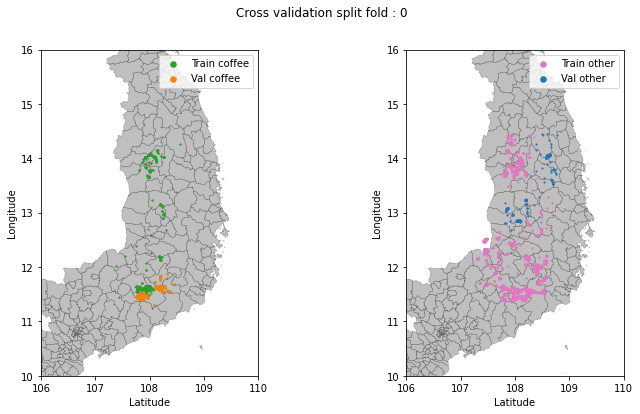

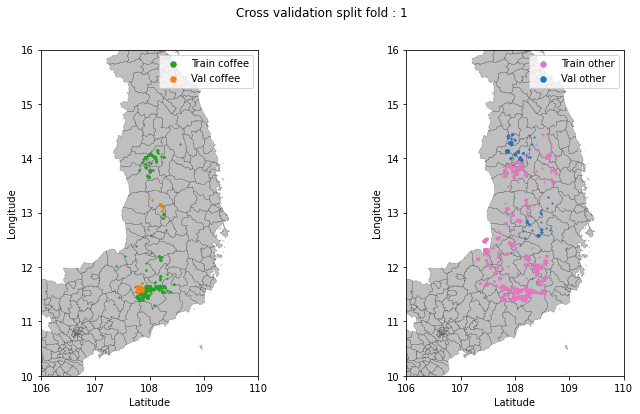

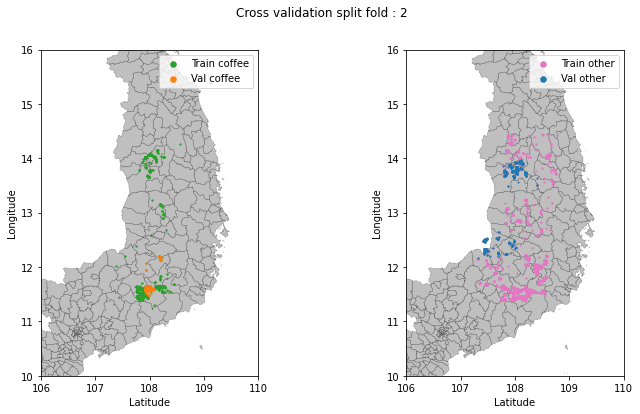

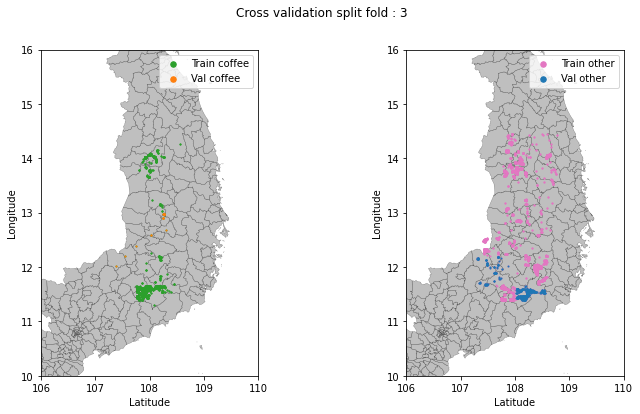

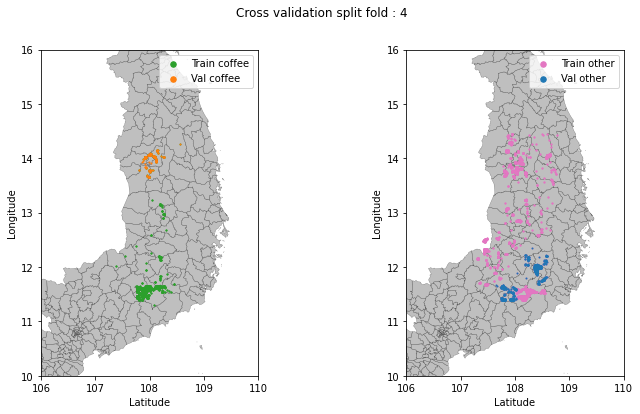

In [16]:
skcv_coffee = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(other_data['geometry'])

fold_index = 0

results = []

for i_fold in range(0, len(list_fold), 2):

    first_fold = list_fold[i_fold]
    second_fold = list_fold[i_fold+1]
    
    train_coffee = np.concatenate([first_fold["train_coffee"], second_fold["train_coffee"]])
    val_coffee = np.concatenate([first_fold["val_coffee"], second_fold["val_coffee"]])
    train_other = np.concatenate([first_fold["train_other"], second_fold["train_other"]])
    val_other = np.concatenate([first_fold["val_other"], second_fold["val_other"]])
    
    geo_train = coffee_data.iloc[train_coffee].append(other_data.iloc[train_other], ignore_index=True)
    geo_val = coffee_data.iloc[val_coffee].append(other_data.iloc[val_other], ignore_index=True)
    
    print(f"Fold {fold_index+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {fold_index+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {fold_index+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {fold_index+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print("-----")

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {fold_index}")
    
    print(f"Training for fold {fold_index}")

    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

    fold_index+=1

In [17]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [18]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.81328125
Stdev accuracy : 0.04490658707249973


Mean loss : 0.47894980311393737
Stdev loss : 0.05015097601057497


Mean precision : 0.9178672432899475
Stdev precision : 0.0738321460496677


Mean recall : 0.8066516876220703
Stdev recall : 0.06774728165123221


Mean F1-Score : 0.8538654512458315
Stdev F1-Score : 0.034182052731561316


In [16]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Coffee/strat_spacv_coffee_32_1/strat_spacv_coffee_32_1_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})
#restored_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

In [17]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

data_test.loc[data_test['label'] != 2, 'label'] = 1
data_test.loc[data_test['label'] == 2, 'label'] = 0

1/1 [==============================] - 6s 6s/step - loss: 0.6726 - accuracy: 0.7042 - precision: 0.7732 - recall: 0.8785
              precision    recall  f1-score   support

           0       0.22      0.12      0.16       211
           1       0.78      0.87      0.82       749

    accuracy                           0.71       960
   macro avg       0.50      0.50      0.49       960
weighted avg       0.66      0.71      0.68       960

F1-Score : 0.8244178728760226


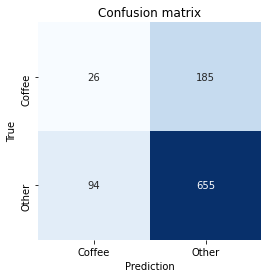

In [18]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

### Stratified cross-val

In [8]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [9]:
nb_0 = len(data_train[data_train['label']==0])
nb_1 = len(data_train[data_train['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [10]:
# Params
BATCH_SIZE = 256
EPOCH = 300
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'start_coffee_300E_focal_2'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [11]:

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(loss=BinaryFocalLoss(gamma=2), optimizer=Adam(learning_rate=LEARNING_RATE), metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper],
                                class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1
    

Epoch 1/300
15/15 [==============================] - 20s 771ms/step - loss: 0.5212 - accuracy: 0.5594 - precision: 0.7806 - recall: 0.5906 - val_loss: 0.4492 - val_accuracy: 0.7201 - val_precision: 0.8429 - val_recall: 0.7782
Epoch 2/300
15/15 [==============================] - 9s 612ms/step - loss: 0.5094 - accuracy: 0.5752 - precision: 0.7648 - recall: 0.6198 - val_loss: 0.4413 - val_accuracy: 0.7266 - val_precision: 0.8602 - val_recall: 0.7662
Epoch 3/300
15/15 [==============================] - 9s 619ms/step - loss: 0.4908 - accuracy: 0.6080 - precision: 0.7894 - recall: 0.6524 - val_loss: 0.4343 - val_accuracy: 0.7279 - val_precision: 0.8661 - val_recall: 0.7573
Epoch 4/300
15/15 [==============================] - 9s 616ms/step - loss: 0.4822 - accuracy: 0.6154 - precision: 0.8024 - recall: 0.6457 - val_loss: 0.4305 - val_accuracy: 0.7240 - val_precision: 0.9022 - val_recall: 0.7131
Epoch 5/300
15/15 [==============================] - 9s 603ms/step - loss: 0.4742 - accuracy: 0.615

15/15 [==============================] - 9s 632ms/step - loss: 0.2894 - accuracy: 0.7883 - precision: 0.9238 - recall: 0.7870 - val_loss: 0.2812 - val_accuracy: 0.7917 - val_precision: 0.9367 - val_recall: 0.7806
Epoch 74/300
15/15 [==============================] - 9s 638ms/step - loss: 0.2803 - accuracy: 0.8007 - precision: 0.9347 - recall: 0.7950 - val_loss: 0.2812 - val_accuracy: 0.7891 - val_precision: 0.9391 - val_recall: 0.7707
Epoch 75/300
15/15 [==============================] - 9s 645ms/step - loss: 0.2890 - accuracy: 0.7856 - precision: 0.9214 - recall: 0.7850 - val_loss: 0.2785 - val_accuracy: 0.8060 - val_precision: 0.9605 - val_recall: 0.7804
Epoch 76/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2821 - accuracy: 0.7943 - precision: 0.9376 - recall: 0.7815 - val_loss: 0.2794 - val_accuracy: 0.7917 - val_precision: 0.9443 - val_recall: 0.7750
Epoch 77/300
15/15 [==============================] - 9s 620ms/step - loss: 0.2825 - accuracy: 0.7974 - preci

15/15 [==============================] - 9s 639ms/step - loss: 0.2284 - accuracy: 0.8001 - precision: 0.9350 - recall: 0.7915 - val_loss: 0.2215 - val_accuracy: 0.8125 - val_precision: 0.9478 - val_recall: 0.7923
Epoch 146/300
15/15 [==============================] - 9s 630ms/step - loss: 0.2296 - accuracy: 0.8015 - precision: 0.9452 - recall: 0.7866 - val_loss: 0.2205 - val_accuracy: 0.8294 - val_precision: 0.9679 - val_recall: 0.8074
Epoch 147/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2285 - accuracy: 0.8020 - precision: 0.9352 - recall: 0.7922 - val_loss: 0.2211 - val_accuracy: 0.8190 - val_precision: 0.9530 - val_recall: 0.8007
Epoch 148/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2218 - accuracy: 0.8095 - precision: 0.9397 - recall: 0.8066 - val_loss: 0.2220 - val_accuracy: 0.8229 - val_precision: 0.9503 - val_recall: 0.8115
Epoch 149/300
15/15 [==============================] - 9s 641ms/step - loss: 0.2224 - accuracy: 0.8180 - p

15/15 [==============================] - 9s 642ms/step - loss: 0.3640 - accuracy: 0.7305 - precision: 0.8973 - recall: 0.7266 - val_loss: 0.3419 - val_accuracy: 0.8021 - val_precision: 0.9213 - val_recall: 0.8069
Epoch 35/300
15/15 [==============================] - 9s 653ms/step - loss: 0.3578 - accuracy: 0.7332 - precision: 0.9054 - recall: 0.7265 - val_loss: 0.3410 - val_accuracy: 0.8060 - val_precision: 0.9226 - val_recall: 0.8140
Epoch 36/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3534 - accuracy: 0.7508 - precision: 0.9045 - recall: 0.7445 - val_loss: 0.3367 - val_accuracy: 0.8164 - val_precision: 0.9129 - val_recall: 0.8354
Epoch 37/300
15/15 [==============================] - 9s 628ms/step - loss: 0.3521 - accuracy: 0.7461 - precision: 0.9042 - recall: 0.7454 - val_loss: 0.3334 - val_accuracy: 0.8164 - val_precision: 0.9198 - val_recall: 0.8296
Epoch 38/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3535 - accuracy: 0.7415 - preci

15/15 [==============================] - 9s 633ms/step - loss: 0.2526 - accuracy: 0.8038 - precision: 0.9298 - recall: 0.8020 - val_loss: 0.2384 - val_accuracy: 0.8451 - val_precision: 0.9266 - val_recall: 0.8647
Epoch 107/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2523 - accuracy: 0.7867 - precision: 0.9246 - recall: 0.7866 - val_loss: 0.2370 - val_accuracy: 0.8633 - val_precision: 0.9352 - val_recall: 0.8783
Epoch 108/300
15/15 [==============================] - 9s 623ms/step - loss: 0.2532 - accuracy: 0.7903 - precision: 0.9305 - recall: 0.7790 - val_loss: 0.2381 - val_accuracy: 0.8477 - val_precision: 0.9316 - val_recall: 0.8630
Epoch 109/300
15/15 [==============================] - 9s 632ms/step - loss: 0.2558 - accuracy: 0.7921 - precision: 0.9156 - recall: 0.7972 - val_loss: 0.2361 - val_accuracy: 0.8555 - val_precision: 0.9404 - val_recall: 0.8647
Epoch 110/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2491 - accuracy: 0.7934 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3204 - accuracy: 0.7739 - precision: 0.9254 - recall: 0.7616 - val_loss: 0.3077 - val_accuracy: 0.8008 - val_precision: 0.9270 - val_recall: 0.8020
Epoch 53/300
15/15 [==============================] - 9s 634ms/step - loss: 0.3228 - accuracy: 0.7497 - precision: 0.9185 - recall: 0.7403 - val_loss: 0.3040 - val_accuracy: 0.8047 - val_precision: 0.9249 - val_recall: 0.8069
Epoch 54/300
15/15 [==============================] - 9s 635ms/step - loss: 0.3185 - accuracy: 0.7707 - precision: 0.9240 - recall: 0.7629 - val_loss: 0.3049 - val_accuracy: 0.7995 - val_precision: 0.9249 - val_recall: 0.7958
Epoch 55/300
15/15 [==============================] - 9s 629ms/step - loss: 0.3142 - accuracy: 0.7604 - precision: 0.9215 - recall: 0.7536 - val_loss: 0.3018 - val_accuracy: 0.8125 - val_precision: 0.9294 - val_recall: 0.8144
Epoch 56/300
15/15 [==============================] - 9s 631ms/step - loss: 0.3167 - accuracy: 0.7524 - preci

15/15 [==============================] - 9s 627ms/step - loss: 0.2386 - accuracy: 0.8119 - precision: 0.9371 - recall: 0.8066 - val_loss: 0.2274 - val_accuracy: 0.8320 - val_precision: 0.9528 - val_recall: 0.8220
Epoch 125/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2404 - accuracy: 0.8007 - precision: 0.9326 - recall: 0.7943 - val_loss: 0.2265 - val_accuracy: 0.8385 - val_precision: 0.9508 - val_recall: 0.8299
Epoch 126/300
15/15 [==============================] - 9s 640ms/step - loss: 0.2358 - accuracy: 0.8148 - precision: 0.9334 - recall: 0.8141 - val_loss: 0.2264 - val_accuracy: 0.8255 - val_precision: 0.9492 - val_recall: 0.8182
Epoch 127/300
15/15 [==============================] - 9s 634ms/step - loss: 0.2362 - accuracy: 0.8138 - precision: 0.9446 - recall: 0.8020 - val_loss: 0.2253 - val_accuracy: 0.8229 - val_precision: 0.9365 - val_recall: 0.8194
Epoch 128/300
15/15 [==============================] - 9s 624ms/step - loss: 0.2341 - accuracy: 0.8096 - p

15/15 [==============================] - 9s 635ms/step - loss: 0.3189 - accuracy: 0.7660 - precision: 0.9276 - recall: 0.7487 - val_loss: 0.3023 - val_accuracy: 0.8021 - val_precision: 0.9296 - val_recall: 0.7979
Epoch 52/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3199 - accuracy: 0.7610 - precision: 0.9228 - recall: 0.7431 - val_loss: 0.2976 - val_accuracy: 0.8034 - val_precision: 0.9323 - val_recall: 0.8000
Epoch 53/300
15/15 [==============================] - 9s 622ms/step - loss: 0.3237 - accuracy: 0.7581 - precision: 0.9073 - recall: 0.7498 - val_loss: 0.2992 - val_accuracy: 0.8034 - val_precision: 0.9359 - val_recall: 0.7969
Epoch 54/300
15/15 [==============================] - 9s 632ms/step - loss: 0.3109 - accuracy: 0.7645 - precision: 0.9278 - recall: 0.7499 - val_loss: 0.2979 - val_accuracy: 0.7969 - val_precision: 0.9393 - val_recall: 0.7864
Epoch 55/300
15/15 [==============================] - 9s 640ms/step - loss: 0.3154 - accuracy: 0.7709 - preci

15/15 [==============================] - 9s 626ms/step - loss: 0.2402 - accuracy: 0.7941 - precision: 0.9309 - recall: 0.7864 - val_loss: 0.2246 - val_accuracy: 0.8242 - val_precision: 0.9449 - val_recall: 0.8177
Epoch 124/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2389 - accuracy: 0.8005 - precision: 0.9318 - recall: 0.7950 - val_loss: 0.2284 - val_accuracy: 0.8073 - val_precision: 0.9375 - val_recall: 0.7990
Epoch 125/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2396 - accuracy: 0.7983 - precision: 0.9359 - recall: 0.7826 - val_loss: 0.2239 - val_accuracy: 0.8242 - val_precision: 0.9483 - val_recall: 0.8140
Epoch 126/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2319 - accuracy: 0.7960 - precision: 0.9398 - recall: 0.7809 - val_loss: 0.2219 - val_accuracy: 0.8229 - val_precision: 0.9429 - val_recall: 0.8174
Epoch 127/300
15/15 [==============================] - 9s 621ms/step - loss: 0.2322 - accuracy: 0.7998 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3066 - accuracy: 0.7701 - precision: 0.9304 - recall: 0.7591 - val_loss: 0.3024 - val_accuracy: 0.7826 - val_precision: 0.9314 - val_recall: 0.7698
Epoch 58/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3069 - accuracy: 0.7802 - precision: 0.9258 - recall: 0.7732 - val_loss: 0.3012 - val_accuracy: 0.8021 - val_precision: 0.9479 - val_recall: 0.7818
Epoch 59/300
15/15 [==============================] - 9s 624ms/step - loss: 0.3124 - accuracy: 0.7614 - precision: 0.9144 - recall: 0.7529 - val_loss: 0.3000 - val_accuracy: 0.7865 - val_precision: 0.9490 - val_recall: 0.7615
Epoch 60/300
15/15 [==============================] - 9s 630ms/step - loss: 0.3084 - accuracy: 0.7569 - precision: 0.9183 - recall: 0.7521 - val_loss: 0.2963 - val_accuracy: 0.7839 - val_precision: 0.9367 - val_recall: 0.7655
Epoch 61/300
15/15 [==============================] - 9s 644ms/step - loss: 0.3127 - accuracy: 0.7641 - preci

In [16]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [17]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.58359375
Stdev accuracy : 0.07807029334596483


Mean loss : 0.834881043434143
Stdev loss : 0.1612857133843908


Mean precision : 0.7884676456451416
Stdev precision : 0.16546708969100746


Mean recall : 0.7146665096282959
Stdev recall : 0.1829823240399447


Mean F1-Score : 0.7121207962023967
Stdev F1-Score : 0.06579899948742093


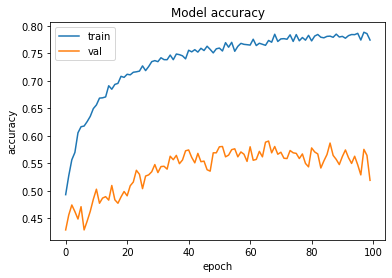

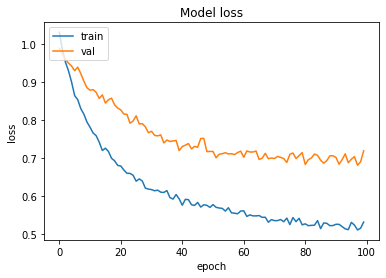

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Coffee/start_coffee_300E_focal_2/start_coffee_300E_focal_2_3.h5"), custom_objects={'LeakyReLU':LeakyReLU})

In [22]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

1/1 [==============================] - 3s 3s/step - loss: 0.2277 - accuracy: 0.8257 - precision: 0.9414 - recall: 0.8211
              precision    recall  f1-score   support

           0       0.57      0.82      0.67       100
           1       0.93      0.80      0.86       313

    accuracy                           0.81       413
   macro avg       0.75      0.81      0.77       413
weighted avg       0.85      0.81      0.82       413

F1-Score : 0.8625429553264605


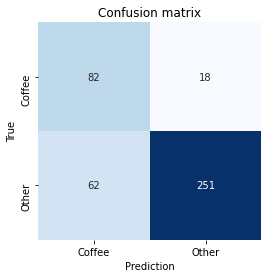

In [23]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Culture vs no culture

In [8]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

In [9]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_culture)
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
np.random.shuffle(path_no_culture)
class_no_culture = [1]*len(path_no_culture)

In [10]:
file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25, random_state=42)

In [11]:
BATCH_SIZE = 64
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 2
EPOCH = 100
RUN_NAME = 'transfer_culture_vietnam_params'
LOGS_PATH = 'logs'

In [13]:
train_generator = generator(path_train, y_train, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)

## Model creation

In [12]:
model_culture = create_model()
model_culture.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv5_block27_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block27_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block27_concat (Concatena (None, 2, 2, 1760)   0           conv5_block26_concat[0][0]       
                                                                 conv5_block27_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_bn (BatchNormal (None, 2, 2, 1760)   7040        conv5_block27_concat[0][0]       
__________________________________________________________________________________________________
conv5_block28_0_relu (Activatio (None, 2, 2, 1760)   0           conv5_block28_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block28_1_conv (Conv2D)   (None, 2, 2, 128)    225280      conv5_block28_0_relu[0][0]       
__________

In [16]:
# Run only for modify input shape
model_culture = change_model(model_culture, new_input_shape=(None, 32,32,13))
model_culture.summary()

Loaded layer input_1
Loaded layer zero_padding2d
Loaded layer conv1/conv
Loaded layer conv1/bn
Loaded layer conv1/relu
Loaded layer zero_padding2d_1
Loaded layer pool1
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_0_relu
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_concat
Loaded layer conv2_block2_0_bn
Loaded layer conv2_block2_0_relu
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_concat
Loaded layer conv2_block3_0_bn
Loaded layer conv2_block3_0_relu
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded layer conv2_block3_concat
Loaded layer conv2_block4_0_bn
Loaded layer conv2_block4_0_relu
Loaded layer conv2_block4_1_conv
Loaded layer conv2_block4_1_bn
Loaded layer conv2_bloc

Loaded layer conv4_block23_concat
Loaded layer conv4_block24_0_bn
Loaded layer conv4_block24_0_relu
Loaded layer conv4_block24_1_conv
Loaded layer conv4_block24_1_bn
Loaded layer conv4_block24_1_relu
Loaded layer conv4_block24_2_conv
Loaded layer conv4_block24_concat
Loaded layer conv4_block25_0_bn
Loaded layer conv4_block25_0_relu
Loaded layer conv4_block25_1_conv
Loaded layer conv4_block25_1_bn
Loaded layer conv4_block25_1_relu
Loaded layer conv4_block25_2_conv
Loaded layer conv4_block25_concat
Loaded layer conv4_block26_0_bn
Loaded layer conv4_block26_0_relu
Loaded layer conv4_block26_1_conv
Loaded layer conv4_block26_1_bn
Loaded layer conv4_block26_1_relu
Loaded layer conv4_block26_2_conv
Loaded layer conv4_block26_concat
Loaded layer conv4_block27_0_bn
Loaded layer conv4_block27_0_relu
Loaded layer conv4_block27_1_conv
Loaded layer conv4_block27_1_bn
Loaded layer conv4_block27_1_relu
Loaded layer conv4_block27_2_conv
Loaded layer conv4_block27_concat
Loaded layer conv4_block28_0_b

Loaded layer conv5_block17_concat
Loaded layer conv5_block18_0_bn
Loaded layer conv5_block18_0_relu
Loaded layer conv5_block18_1_conv
Loaded layer conv5_block18_1_bn
Loaded layer conv5_block18_1_relu
Loaded layer conv5_block18_2_conv
Loaded layer conv5_block18_concat
Loaded layer conv5_block19_0_bn
Loaded layer conv5_block19_0_relu
Loaded layer conv5_block19_1_conv
Loaded layer conv5_block19_1_bn
Loaded layer conv5_block19_1_relu
Loaded layer conv5_block19_2_conv
Loaded layer conv5_block19_concat
Loaded layer conv5_block20_0_bn
Loaded layer conv5_block20_0_relu
Loaded layer conv5_block20_1_conv
Loaded layer conv5_block20_1_bn
Loaded layer conv5_block20_1_relu
Loaded layer conv5_block20_2_conv
Loaded layer conv5_block20_concat
Loaded layer conv5_block21_0_bn
Loaded layer conv5_block21_0_relu
Loaded layer conv5_block21_1_conv
Loaded layer conv5_block21_1_bn
Loaded layer conv5_block21_1_relu
Loaded layer conv5_block21_2_conv
Loaded layer conv5_block21_concat
Loaded layer conv5_block22_0_b

__________________________________________________________________________________________________
conv4_block15_0_bn (BatchNormal (None, 2, 2, 704)    2816        conv4_block14_concat[0][0]       
__________________________________________________________________________________________________
conv4_block15_0_relu (Activatio (None, 2, 2, 704)    0           conv4_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 2, 2, 128)    90112       conv4_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 2, 2, 128)    512         conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 2, 2, 128)    0           conv4_block15_1_bn[0][0]         
__________

In [57]:
os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))

earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
#tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/transfer_culture_vietnam_params'

In [58]:


model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/100
174/174 [==============================] - 39s 188ms/step - loss: 1.7473 - accuracy: 0.5251 - val_loss: 1.6164 - val_accuracy: 0.5665
Epoch 2/100
174/174 [==============================] - 31s 177ms/step - loss: 1.6062 - accuracy: 0.5555 - val_loss: 1.4959 - val_accuracy: 0.6498
Epoch 3/100
174/174 [==============================] - 31s 177ms/step - loss: 1.4909 - accuracy: 0.5773 - val_loss: 1.3913 - val_accuracy: 0.6856
Epoch 4/100
174/174 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.6003

KeyboardInterrupt: 

In [18]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.npy'),history.history)

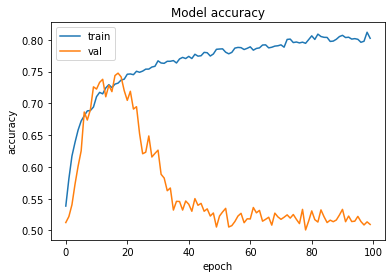

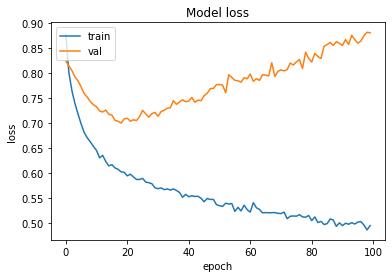

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [20]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model_culture.evaluate_generator(test_generator,30)

[0.46674337685108186, 0.8041667]

In [42]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [43]:
cm = confusion_matrix(Y_true, Y_pred)

In [41]:
plot_confusion_matrix(cm)

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'

In [45]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1055
           1       0.75      0.73      0.74       865

    accuracy                           0.77      1920
   macro avg       0.76      0.76      0.76      1920
weighted avg       0.77      0.77      0.77      1920

F1-Score : 0.7366568914956012


### Spatial - Cross Validation

In [12]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

In [13]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_train_32.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

data_train = data_train[data_train['label'].isin(culture_list + no_culture_list)]
data_train.loc[data_train['label'].isin(culture_list), 'label'] = 0
data_train.loc[data_train['label'].isin(no_culture_list), 'label'] =1

In [14]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'spacv_culture32_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

In [18]:
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

Training for fold 0
Epoch 1/100
70/70 [==============================] - 18s 154ms/step - loss: 0.9279 - accuracy: 0.6142 - precision: 0.5461 - recall: 0.6319 - val_loss: 0.9074 - val_accuracy: 0.5215 - val_precision: 0.9836 - val_recall: 0.4645
Epoch 2/100
70/70 [==============================] - 8s 122ms/step - loss: 0.7050 - accuracy: 0.8051 - precision: 0.7954 - recall: 0.7232 - val_loss: 0.9071 - val_accuracy: 0.5225 - val_precision: 0.9840 - val_recall: 0.4715
Epoch 3/100
70/70 [==============================] - 9s 123ms/step - loss: 0.5697 - accuracy: 0.8535 - precision: 0.8867 - recall: 0.7480 - val_loss: 0.9368 - val_accuracy: 0.5156 - val_precision: 0.9907 - val_recall: 0.4635
Epoch 4/100
70/70 [==============================] - 9s 124ms/step - loss: 0.5435 - accuracy: 0.8462 - precision: 0.8825 - recall: 0.7422 - val_loss: 0.8781 - val_accuracy: 0.5410 - val_precision: 0.9847 - val_recall: 0.4934
Epoch 5/100
70/70 [==============================] - 9s 123ms/step - loss: 0.47

50/50 [==============================] - 8s 166ms/step - loss: 0.2914 - accuracy: 0.9229 - precision: 0.9489 - recall: 0.9400 - val_loss: 1.0207 - val_accuracy: 0.5254 - val_precision: 0.3525 - val_recall: 0.9720
Epoch 20/100
50/50 [==============================] - 8s 166ms/step - loss: 0.3083 - accuracy: 0.9109 - precision: 0.9334 - recall: 0.9357 - val_loss: 0.9623 - val_accuracy: 0.5620 - val_precision: 0.3678 - val_recall: 0.9366
Epoch 21/100
50/50 [==============================] - 8s 166ms/step - loss: 0.2928 - accuracy: 0.9204 - precision: 0.9467 - recall: 0.9412 - val_loss: 0.9525 - val_accuracy: 0.5718 - val_precision: 0.3896 - val_recall: 0.9595
Epoch 22/100
50/50 [==============================] - 8s 165ms/step - loss: 0.2902 - accuracy: 0.9194 - precision: 0.9418 - recall: 0.9407 - val_loss: 0.9975 - val_accuracy: 0.5474 - val_precision: 0.3549 - val_recall: 0.9653
Epoch 23/100
50/50 [==============================] - 8s 166ms/step - loss: 0.3093 - accuracy: 0.9087 - preci

50/50 [==============================] - 8s 165ms/step - loss: 0.2110 - accuracy: 0.9474 - precision: 0.9591 - recall: 0.9647 - val_loss: 1.2126 - val_accuracy: 0.5654 - val_precision: 0.3659 - val_recall: 0.9486
Epoch 92/100
50/50 [==============================] - 8s 165ms/step - loss: 0.2038 - accuracy: 0.9429 - precision: 0.9628 - recall: 0.9520 - val_loss: 1.2807 - val_accuracy: 0.5396 - val_precision: 0.3655 - val_recall: 0.9620
Epoch 93/100
50/50 [==============================] - 8s 166ms/step - loss: 0.2174 - accuracy: 0.9360 - precision: 0.9499 - recall: 0.9582 - val_loss: 1.1675 - val_accuracy: 0.5557 - val_precision: 0.3683 - val_recall: 0.9538
Epoch 94/100
50/50 [==============================] - 8s 165ms/step - loss: 0.2207 - accuracy: 0.9447 - precision: 0.9557 - recall: 0.9614 - val_loss: 1.1342 - val_accuracy: 0.5742 - val_precision: 0.3729 - val_recall: 0.9695
Epoch 95/100
50/50 [==============================] - 8s 166ms/step - loss: 0.2247 - accuracy: 0.9357 - preci

82/82 [==============================] - 9s 106ms/step - loss: 0.3205 - accuracy: 0.8982 - precision: 0.9131 - recall: 0.8944 - val_loss: 0.5903 - val_accuracy: 0.7734 - val_precision: 0.2364 - val_recall: 0.4483
Epoch 63/100
82/82 [==============================] - 9s 106ms/step - loss: 0.3075 - accuracy: 0.9025 - precision: 0.9175 - recall: 0.8982 - val_loss: 0.5029 - val_accuracy: 0.8086 - val_precision: 0.4167 - val_recall: 0.4878
Epoch 64/100
82/82 [==============================] - 9s 106ms/step - loss: 0.2860 - accuracy: 0.9128 - precision: 0.9359 - recall: 0.9036 - val_loss: 0.5090 - val_accuracy: 0.8203 - val_precision: 0.2558 - val_recall: 0.4400
Epoch 65/100
82/82 [==============================] - 9s 106ms/step - loss: 0.2708 - accuracy: 0.9223 - precision: 0.9432 - recall: 0.9166 - val_loss: 0.5815 - val_accuracy: 0.7852 - val_precision: 0.3400 - val_recall: 0.4359
Epoch 66/100
82/82 [==============================] - 9s 106ms/step - loss: 0.3186 - accuracy: 0.9007 - preci

76/76 [==============================] - 8s 112ms/step - loss: 0.3108 - accuracy: 0.9034 - precision: 0.9166 - recall: 0.8960 - val_loss: 0.3543 - val_accuracy: 0.8809 - val_precision: 0.9366 - val_recall: 0.8000
Epoch 49/100
76/76 [==============================] - 8s 111ms/step - loss: 0.3312 - accuracy: 0.9000 - precision: 0.9116 - recall: 0.8885 - val_loss: 0.3868 - val_accuracy: 0.8809 - val_precision: 0.9330 - val_recall: 0.8058
Epoch 50/100
76/76 [==============================] - 8s 111ms/step - loss: 0.3081 - accuracy: 0.9041 - precision: 0.9102 - recall: 0.9017 - val_loss: 0.4816 - val_accuracy: 0.8496 - val_precision: 0.9461 - val_recall: 0.7452
Epoch 51/100
76/76 [==============================] - 8s 112ms/step - loss: 0.3206 - accuracy: 0.9049 - precision: 0.9122 - recall: 0.9024 - val_loss: 0.4423 - val_accuracy: 0.8555 - val_precision: 0.9391 - val_recall: 0.7490
Epoch 52/100
76/76 [==============================] - 8s 111ms/step - loss: 0.3097 - accuracy: 0.9086 - preci

54/54 [==============================] - 8s 142ms/step - loss: 0.3380 - accuracy: 0.9113 - precision: 0.9196 - recall: 0.8984 - val_loss: 0.3553 - val_accuracy: 0.8629 - val_precision: 0.9168 - val_recall: 0.8863
Epoch 30/100
54/54 [==============================] - 8s 142ms/step - loss: 0.3365 - accuracy: 0.9147 - precision: 0.9211 - recall: 0.9057 - val_loss: 0.3449 - val_accuracy: 0.8608 - val_precision: 0.9099 - val_recall: 0.8876
Epoch 31/100
54/54 [==============================] - 8s 143ms/step - loss: 0.3287 - accuracy: 0.9170 - precision: 0.9314 - recall: 0.8878 - val_loss: 0.3584 - val_accuracy: 0.8558 - val_precision: 0.9088 - val_recall: 0.8920
Epoch 32/100
54/54 [==============================] - 8s 141ms/step - loss: 0.3250 - accuracy: 0.9191 - precision: 0.9238 - recall: 0.9100 - val_loss: 0.3673 - val_accuracy: 0.8601 - val_precision: 0.9096 - val_recall: 0.8883
Epoch 33/100
54/54 [==============================] - 8s 142ms/step - loss: 0.3226 - accuracy: 0.9121 - preci

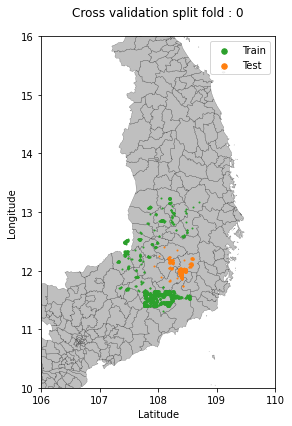

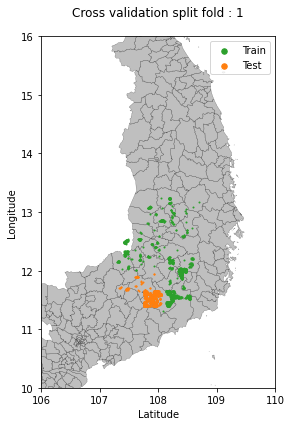

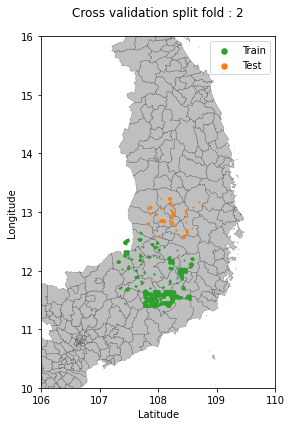

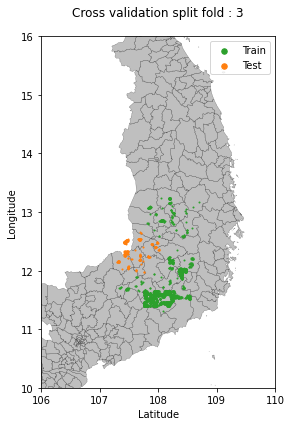

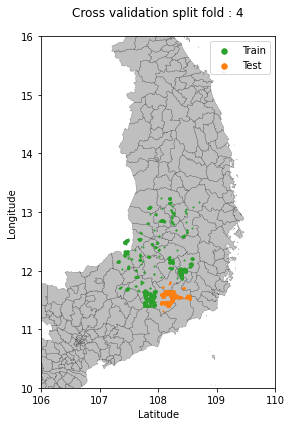

In [19]:
skcv = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(data_train['geometry'])

fold_index = 0

results = []

for train, validation in skcv:
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]

    display_cross_val_map(geo_train, geo_val, map, f"Cross validation split fold : {fold_index}")

    print(f"Training for fold {fold_index}")

    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print("\n")

    K.clear_session()

    fold_index+=1

In [20]:
losses, accs, precisions, recalls = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")

Mean accuracy : 0.6953125
Stdev accuracy : 0.16692078608766794


Mean loss : 0.7048969566822052
Stdev loss : 0.35099698348291275


Mean precision : 0.6997291266918182
Stdev precision : 0.31808202895113946


Mean recall : 0.6868039131164551
Stdev recall : 0.2020345579847733


In [21]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [30]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test_32.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

data_test = data_test[data_test['label'].isin(culture_list + no_culture_list)]
data_test.loc[data_test['label'].isin(culture_list), 'label'] = 0
data_test.loc[data_test['label'].isin(no_culture_list), 'label'] =1

In [35]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Culture/spacv_culture32_1/spacv_culture32_1_3.h5"), custom_objects={'LeakyReLU':LeakyReLU})

1/1 [==============================] - 2s 2s/step - loss: 0.6015 - accuracy: 0.8497 - precision: 0.9375 - recall: 0.2830
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       412
           1       0.90      0.25      0.39       107

    accuracy                           0.84       519
   macro avg       0.87      0.62      0.65       519
weighted avg       0.85      0.84      0.80       519

F1-Score : 0.3941605839416058


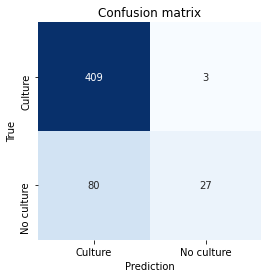

In [36]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=519)
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

### Stratified cross-val

In [10]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_train_culture.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

In [11]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'strat_culture_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [12]:
from sklearn.model_selection import StratifiedKFold

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1

Epoch 1/100
36/36 [==============================] - 15s 207ms/step - loss: 0.9168 - accuracy: 0.6147 - precision: 0.5715 - recall: 0.7572 - val_loss: 0.6544 - val_accuracy: 0.8438 - val_precision: 0.9822 - val_recall: 0.6831
Epoch 2/100
36/36 [==============================] - 5s 140ms/step - loss: 0.6750 - accuracy: 0.8042 - precision: 0.8781 - recall: 0.6799 - val_loss: 0.5700 - val_accuracy: 0.8457 - val_precision: 0.9465 - val_recall: 0.7195
Epoch 3/100
36/36 [==============================] - 5s 139ms/step - loss: 0.5826 - accuracy: 0.8253 - precision: 0.8821 - recall: 0.7337 - val_loss: 0.5317 - val_accuracy: 0.8496 - val_precision: 0.9583 - val_recall: 0.6970
Epoch 4/100
36/36 [==============================] - 5s 137ms/step - loss: 0.5304 - accuracy: 0.8463 - precision: 0.9062 - recall: 0.7449 - val_loss: 0.4913 - val_accuracy: 0.8691 - val_precision: 0.9561 - val_recall: 0.7717
Epoch 5/100
36/36 [==============================] - 5s 140ms/step - loss: 0.4935 - accuracy: 0.862

36/36 [==============================] - 5s 145ms/step - loss: 0.4696 - accuracy: 0.8465 - precision: 0.8708 - recall: 0.7777 - val_loss: 0.3863 - val_accuracy: 0.8984 - val_precision: 0.9670 - val_recall: 0.8200
Epoch 10/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4299 - accuracy: 0.8675 - precision: 0.9011 - recall: 0.8073 - val_loss: 0.4216 - val_accuracy: 0.8945 - val_precision: 0.9548 - val_recall: 0.7860
Epoch 11/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3934 - accuracy: 0.8938 - precision: 0.9317 - recall: 0.8421 - val_loss: 0.3964 - val_accuracy: 0.8926 - val_precision: 0.9431 - val_recall: 0.8223
Epoch 12/100
36/36 [==============================] - 5s 142ms/step - loss: 0.4338 - accuracy: 0.8701 - precision: 0.8883 - recall: 0.8266 - val_loss: 0.4186 - val_accuracy: 0.8691 - val_precision: 0.9190 - val_recall: 0.7942
Epoch 13/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4366 - accuracy: 0.8766 - preci

36/36 [==============================] - 5s 141ms/step - loss: 0.2772 - accuracy: 0.9272 - precision: 0.9426 - recall: 0.8938 - val_loss: 0.2687 - val_accuracy: 0.9297 - val_precision: 0.9649 - val_recall: 0.8871
Epoch 82/100
36/36 [==============================] - 5s 142ms/step - loss: 0.2630 - accuracy: 0.9224 - precision: 0.9299 - recall: 0.9022 - val_loss: 0.2906 - val_accuracy: 0.9199 - val_precision: 0.9415 - val_recall: 0.8694
Epoch 83/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2618 - accuracy: 0.9316 - precision: 0.9520 - recall: 0.9079 - val_loss: 0.3157 - val_accuracy: 0.9043 - val_precision: 0.9283 - val_recall: 0.8625
Epoch 84/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2722 - accuracy: 0.9262 - precision: 0.9384 - recall: 0.9003 - val_loss: 0.2677 - val_accuracy: 0.9277 - val_precision: 0.9469 - val_recall: 0.9062
Epoch 85/100
36/36 [==============================] - 5s 141ms/step - loss: 0.2490 - accuracy: 0.9340 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.2902 - accuracy: 0.9174 - precision: 0.9157 - recall: 0.9158 - val_loss: 0.2822 - val_accuracy: 0.9277 - val_precision: 0.9358 - val_recall: 0.8987
Epoch 53/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2853 - accuracy: 0.9309 - precision: 0.9493 - recall: 0.9072 - val_loss: 0.2892 - val_accuracy: 0.9336 - val_precision: 0.9824 - val_recall: 0.8814
Epoch 54/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2851 - accuracy: 0.9288 - precision: 0.9475 - recall: 0.9018 - val_loss: 0.2688 - val_accuracy: 0.9277 - val_precision: 0.9309 - val_recall: 0.9197
Epoch 55/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3079 - accuracy: 0.9168 - precision: 0.9252 - recall: 0.8992 - val_loss: 0.2868 - val_accuracy: 0.9297 - val_precision: 0.9532 - val_recall: 0.8996
Epoch 56/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2937 - accuracy: 0.9213 - preci

36/36 [==============================] - 5s 138ms/step - loss: 0.3123 - accuracy: 0.9228 - precision: 0.9366 - recall: 0.8917 - val_loss: 0.2884 - val_accuracy: 0.9238 - val_precision: 0.8920 - val_recall: 0.9489
Epoch 40/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3126 - accuracy: 0.9136 - precision: 0.9186 - recall: 0.8893 - val_loss: 0.2844 - val_accuracy: 0.9238 - val_precision: 0.9053 - val_recall: 0.9322
Epoch 41/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3312 - accuracy: 0.9072 - precision: 0.9126 - recall: 0.8715 - val_loss: 0.2957 - val_accuracy: 0.9043 - val_precision: 0.8806 - val_recall: 0.9328
Epoch 42/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3357 - accuracy: 0.9020 - precision: 0.9160 - recall: 0.8737 - val_loss: 0.2965 - val_accuracy: 0.9121 - val_precision: 0.8953 - val_recall: 0.9277
Epoch 43/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2912 - accuracy: 0.9337 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.3460 - accuracy: 0.9218 - precision: 0.9294 - recall: 0.9004 - val_loss: 0.3943 - val_accuracy: 0.8789 - val_precision: 0.8565 - val_recall: 0.8788
Epoch 20/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3682 - accuracy: 0.9040 - precision: 0.9216 - recall: 0.8721 - val_loss: 0.3818 - val_accuracy: 0.8945 - val_precision: 0.9087 - val_recall: 0.8438
Epoch 21/100
36/36 [==============================] - 5s 136ms/step - loss: 0.3671 - accuracy: 0.9006 - precision: 0.9316 - recall: 0.8526 - val_loss: 0.4088 - val_accuracy: 0.8633 - val_precision: 0.8805 - val_recall: 0.8223
Epoch 22/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3573 - accuracy: 0.8968 - precision: 0.9062 - recall: 0.8724 - val_loss: 0.3579 - val_accuracy: 0.9043 - val_precision: 0.9321 - val_recall: 0.8583
Epoch 23/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3321 - accuracy: 0.9195 - preci

36/36 [==============================] - 5s 137ms/step - loss: 0.2469 - accuracy: 0.9387 - precision: 0.9700 - recall: 0.8974 - val_loss: 0.2920 - val_accuracy: 0.9277 - val_precision: 0.9378 - val_recall: 0.9113
Epoch 92/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2522 - accuracy: 0.9351 - precision: 0.9540 - recall: 0.9085 - val_loss: 0.2703 - val_accuracy: 0.9414 - val_precision: 0.9651 - val_recall: 0.9095
Epoch 93/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2580 - accuracy: 0.9243 - precision: 0.9408 - recall: 0.8981 - val_loss: 0.2701 - val_accuracy: 0.9277 - val_precision: 0.9414 - val_recall: 0.9073
Epoch 94/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2492 - accuracy: 0.9342 - precision: 0.9467 - recall: 0.9144 - val_loss: 0.3196 - val_accuracy: 0.9180 - val_precision: 0.9518 - val_recall: 0.8750
Epoch 95/100
36/36 [==============================] - 5s 135ms/step - loss: 0.2556 - accuracy: 0.9324 - preci

In [13]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.9265625
Stdev accuracy : 0.016646309181767592


Mean loss : 0.27794947624206545
Stdev loss : 0.027769519540595488


Mean precision : 0.9395267963409424
Stdev precision : 0.023373058774516606


Mean recall : 0.8953775048255921
Stdev recall : 0.03805134136252921


Mean F1-Score : 0.9162076730067013
Stdev F1-Score : 0.018911896167159256


In [14]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [15]:
data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_spring_test_culture.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

In [16]:
restored_model = load_model(os.path.join("saved_models/transfer_learning/Culture/strat_culture_1/strat_culture_1_1.h5"), custom_objects={'LeakyReLU':LeakyReLU})

1/1 [==============================] - 5s 5s/step - loss: 0.2659 - accuracy: 0.9307 - precision: 0.9747 - recall: 0.8750
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       199
           1       0.97      0.88      0.92       176

    accuracy                           0.93       375
   macro avg       0.94      0.93      0.93       375
weighted avg       0.93      0.93      0.93       375

F1-Score : 0.9221556886227545


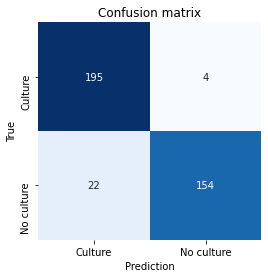

In [17]:
test_generator = generator(data_test['path'].to_numpy(), 
                            data_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(data_test))
restored_model.evaluate(test_generator,steps=1)
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No culture"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

## Model evaluation

In [54]:
restored_model = get_best_cross_val_model(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME), RUN_NAME, results, custom_objects={'LeakyReLU':LeakyReLU})

In [24]:
test_generator = generator(path_test, 
                            y_test, 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=BATCH_SIZE)
restored_model.evaluate(test_generator,steps=30)

30/30 [==============================] - 6s 130ms/step - loss: 0.2563 - accuracy: 0.9328


[0.25634971261024475, 0.932812511920929]

In [25]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

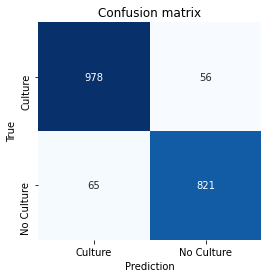

In [27]:
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Culture", "No Culture"])

In [28]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1034
           1       0.94      0.93      0.93       886

    accuracy                           0.94      1920
   macro avg       0.94      0.94      0.94      1920
weighted avg       0.94      0.94      0.94      1920

F1-Score : 0.9313669880884855


In [33]:
geo_test= gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"test_data.csv")))
geo_test['geometry'] = geo_test['geometry'].apply(wkt.loads)

In [34]:
geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold', 'train_data.csv')))
geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)

In [36]:
a = set(geo_train['path'].to_numpy())
b = set(geo_test['path'].to_numpy())

In [37]:
a.intersection(b)

set()